In [27]:
%matplotlib inline

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torchvision.models import VisionTransformer
from tqdm import tqdm
import time
import os
import shutil
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np
import seaborn as sns

c:\Users\Chinmay\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tkinter import Tk
from tkinter.filedialog import askdirectory

# Hide the main Tkinter window
Tk().withdraw()
# Print the selected folder
print(f"Please select the folder from the pop up:")
# Ask the user to select the folder with custom text
home_folder = askdirectory(title="Select the Project_submission folder")

# Check if a folder was selected
if not home_folder:
    print("No folder selected. Exiting.")
    exit()

# Print the selected folder or use it in your script
print(f"Selected folder: {home_folder}")


Please select the folder from the pop up:
Selected folder: D:/Others/Project_Submission_ALL_DATA


In [3]:
def generate_loader( train_dir , test_dir , val_dir):

    batch_size = 32
    train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    num_classes = len(train_dataset.classes)

    return train_loader , test_loader , val_loader

In [4]:

def load_pretrained_vision_transformer(model_name, num_classes, pretrained=True):
    # Load pre-trained Vision Transformer model
    model = timm.create_model(model_name, pretrained=pretrained)

    # Modify classifier head for the specified number of classes
    if hasattr(model, 'head'):
        num_features = model.head.in_features
        model.head = torch.nn.Linear(num_features, num_classes)
    elif hasattr(model, 'classifier'):
        num_features = model.classifier.in_features
        model.classifier = torch.nn.Linear(num_features, num_classes)
    else:
        raise ValueError("Unsupported model architecture, unable to modify classifier head.")

    return model




In [31]:


def test_model(model, test_loader, batch_size=32):


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    print(f'Testing Accuracy: {test_accuracy:.4f}')
    return test_accuracy




def save_accuracy_curves( train_accuracies, val_accuracies, save_path):
    plt.figure(figsize=(4 , 4))
    plt.rcParams['pdf.fonttype']=42
    plt.rcParams['savefig.format'] = 'eps'
    plt.rcParams['savefig.dpi'] = 420
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Vision Transformer')
    plt.legend()
    plt.grid(True)
    #Save the image of accuracy curves
    #plt.savefig(save_path , format= 'png' , dpi = 420)
    plt.show()
   





In [6]:

def calculate_metrics(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

**Vision Transformer for 4 Classes**

In [7]:
# Example usage:
model_name = 'vit_base_patch16_224.augreg_in21k'
num_classes = 4  # Assuming the number of classes is known
pretrained = True   # Set to False if you don't want to use pre-trained weights
model = load_pretrained_vision_transformer(model_name, num_classes, pretrained)

# Load the saved state dictionary
state_dict = torch.load(os.path.join(home_folder,'RESULTS/MODEL_FILES/Model_Files_4_Classes/vision_transformer_model_4_classes.pth') , map_location='cpu')

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Ensure the model is in evaluation mode
model.eval()


# Now your model is loaded and ready to be used for inference

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
c:\Users\Chinmay\anaconda3\envs\tf_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Chinmay\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg_in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [ ]:
train_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/4 Age Groups/train")
val_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/4 Age Groups/val")
test_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/4 Age Groups/test")

In [9]:
train_loader , test_loader , val_loader = generate_loader( train_dir , test_dir , val_dir)

In [10]:
test_accuracy = test_model(model, test_loader, batch_size=32)
print(f"Accuracy : {test_accuracy}")

Testing Accuracy: 0.7216
Accuracy : 0.7216035634743875


In [11]:
calculate_metrics(model, test_loader)

Precision: 0.7253, Recall: 0.7216, F1-score: 0.7224


**Loading Vision Transformer 7 Classes**

In [12]:
# Example usage:
model_name = 'vit_base_patch16_224.augreg_in21k'
num_classes = 7  # Assuming the number of classes is known
pretrained = True   # Set to False if you don't want to use pre-trained weights
model = load_pretrained_vision_transformer(model_name, num_classes, pretrained)

# Load the saved state dictionary
state_dict = torch.load(os.path.join(home_folder,'RESULTS/MODEL_FILES/Model_Files_7_Classes/vision_transformer_model_7_classes.pth') , map_location='cpu')

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Ensure the model is in evaluation mode
model.eval()


# Now your model is loaded and ready to be used for inference

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [ ]:
train_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/7 Age Groups/train")
val_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/7 Age Groups/val")
test_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/7 Age Groups/test")

In [14]:
train_loader , test_loader , val_loader = generate_loader( train_dir , test_dir , val_dir)

In [15]:
test_accuracy = test_model(model, test_loader, batch_size=32)
print(f"Accuracy : {test_accuracy}")

Testing Accuracy: 0.5626
Accuracy : 0.5626423690205011


In [16]:
calculate_metrics(model, test_loader)

Precision: 0.5770, Recall: 0.5626, F1-score: 0.5664


**Loading Vision Transformer for 15 Classes**

In [17]:
# Example usage:
model_name = 'vit_base_patch16_224.augreg_in21k'
num_classes = 15  # Assuming the number of classes is known
pretrained = True   # Set to False if you don't want to use pre-trained weights
model = load_pretrained_vision_transformer(model_name, num_classes, pretrained)

# Load the saved state dictionary
state_dict = torch.load(os.path.join(home_folder,'RESULTS/MODEL_FILES/Model_Files_15_Classes/vision_transformer_model_15_classes.pth') , map_location='cpu')

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Ensure the model is in evaluation mode
model.eval()


# Now your model is loaded and ready to be used for inference

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [ ]:
train_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/15 Age Groups/train")
val_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/15 Age Groups/val")
test_dir = os.path.join(home_folder,"Dataset/Cattle Dentition Datasets after Segmentation/15 Age Groups/test")

In [19]:
train_loader , test_loader , val_loader = generate_loader( train_dir , test_dir , val_dir)

In [20]:
test_accuracy = test_model(model, test_loader, batch_size=32)
print(f"Accuracy : {test_accuracy}")

Testing Accuracy: 0.3697
Accuracy : 0.36971046770601335


In [21]:
calculate_metrics(model, test_loader)

Precision: 0.3746, Recall: 0.3697, F1-score: 0.3689


### VISION TRANSFORM ACCURACY CURVE

### 4 Class ACCURACY CURVE

In [32]:
train_accuracies = [0 ,  0.5125 , 0.6932 , 0.7759 , 0.9049 , 0.9213 , 0.9353 , 0.9477 , 0.9547 , 0.9522 , 0.9547 , 0.9497 , 0.9562 , 0.9557 , 0.9522 , 0.9527]
val_accuracies = [ 0 ,  0.6432 , 0.6690 , 0.6854 , 0.7207 , 0.7324 , 0.7441 , 0.7394 , 0.7418 , 0.7394 , 0.7394 , 0.7394 , 0.7371 , 0.7371, 0.7371 , 0.7371 ]
save_path = os.path.join(home_folder, "RESULTS/RESULT_IMAGES/vt_4_accuracy_curve")


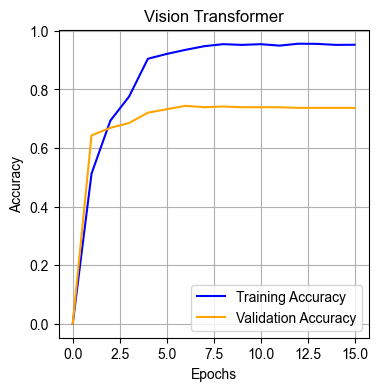

In [33]:
save_accuracy_curves( train_accuracies, val_accuracies, save_path)

### 7 Class ACCURACY CURVE

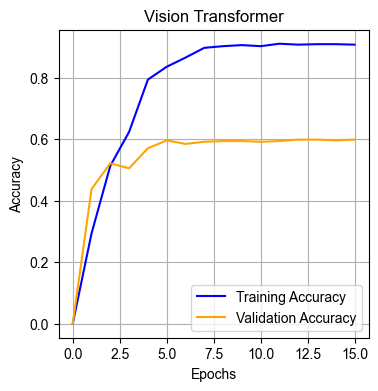

In [34]:
train_accuracies = [0,0.2938, 0.5141, 0.6243, 0.7945, 0.8362, 0.8660, 0.8978, 0.9032, 0.9067, 0.9032, 0.9112, 0.9082, 0.9097, 0.9097, 0.9082]
val_accuracies = [0,0.4382, 0.5221, 0.5058, 0.5711, 0.5967, 0.5851, 0.5921, 0.5944, 0.5944, 0.5921, 0.5944, 0.5991, 0.5991, 0.5967, 0.5991]
save_path = os.path.join(home_folder, "RESULTS/RESULT_IMAGES/vt_7_accuracy_curve")
save_accuracy_curves( train_accuracies, val_accuracies, save_path)

### 15 Class ACCURACY CURVE

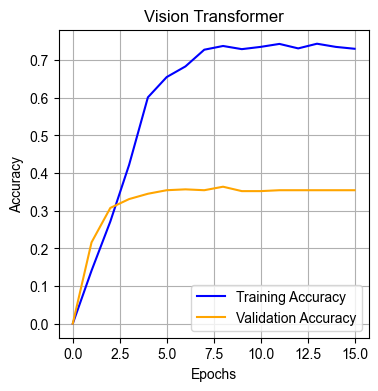

In [35]:

train_accuracies = [0 ,0.1409, 0.2714, 0.4218, 0.6011, 0.6549, 0.6833, 0.7276, 0.7375, 0.7291, 0.7351, 0.7430, 0.7311, 0.7435, 0.7351, 0.7301]
val_accuracies = [0 , 0.2160, 0.3075, 0.3310, 0.3451, 0.3545, 0.3568, 0.3545, 0.3638, 0.3521, 0.3521, 0.3545, 0.3545, 0.3545, 0.3545, 0.3545]
save_path = os.path.join(home_folder, "RESULTS/RESULT_IMAGES/vt_15_accuracy_curve")
save_accuracy_curves( train_accuracies, val_accuracies, save_path)